This notebook illustrates the [LensPerfect](http://adsabs.harvard.edu/abs/2008ApJ...681..814C) method

In [1]:
%matplotlib inline
import grale.lenses as lenses
import grale.cosmology as cosmology
import grale.plotutil as plotutil
import grale.feedback as feedback
import grale.images as images
from grale.constants import *
import numpy as np
import matplotlib.pyplot as plt

cosm = cosmology.Cosmology(0.7, 0.27, 0, 0.73)
V = lambda x,y: np.array([x,y], dtype=np.double)
LI = plotutil.LensInfo

feedback.setDefaultFeedback("notebook")
plotutil.setDefaultAngularUnit(ANGLE_ARCSEC)

In [2]:
# Let's load the real lens, and plot it
realLens = lenses.GravitationalLens.load("reallens_nosheet.lensdata")
size = 220*ANGLE_ARCSEC

lensInfo = LI(realLens, size=size, Ds=1, Dds=1)
plotutil.plotDensityInteractive(lensInfo);

Text(value='')

FloatProgress(value=0.0)

In [3]:
# The lens' angular diameter distance is 0.4 in this cosmology, as is illustrated by
# letting an algorithm look for the match
Dd = realLens.getLensDistance()
zd = min(cosm.findRedshiftForAngularDiameterDistance(Dd))
zd

0.40000056290430064

Text(value='')

FloatProgress(value=0.0)

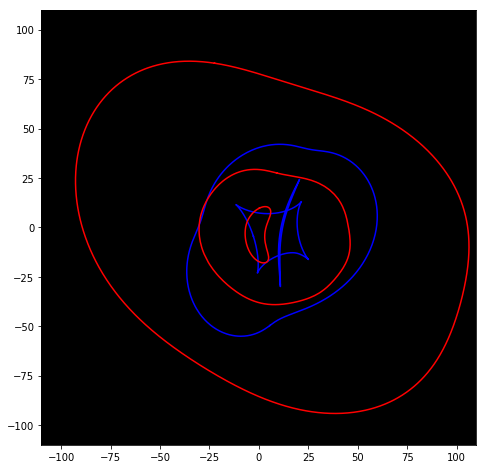

In [4]:
# We'll plot the critical curves and caustics. Not only do they look nice,
# but this also provides us with a LensPlane instance that we'll use below
plt.figure(figsize=(8,8))
plotutil.plotImagePlane(lensInfo);

In [5]:
# Here we obtain the 'LensPlane' for this lens, which contains a map of
# deflection angles at a large number of grid points. We'll be able to
# use this to trace a point in the source plane to its corresponding
# image locations
lensplane = lensInfo.getLensPlane()

Text(value='')

In [6]:
# We're going to create a list of sources that have multiple images, and
# for each source we'll store the position in the source plane (beta) and
# the corresponding images in the image plane (thetas).
sources = [ ]
numSources = 50

while len(sources) < numSources:
    # Pick a redshift that's somewhat larger than the lens's, but limit it
    # to 4
    zs = np.random.uniform(zd*1.2, 4.0)
    
    # Obtain the relevant angular diameter distances for the source
    Dds = cosm.getAngularDiameterDistance(zd,zs)
    Ds = cosm.getAngularDiameterDistance(zs)
    
    # Create an ImagePlane instance for this source, which is basically just
    # the LensPlane but which also takes the source's angular diameter distances
    # into account
    imgplane = images.ImagePlane(lensplane, Ds, Dds)
    
    # Pick a point in the source plane, and trace it to the image plane
    beta = np.random.uniform(-40,40, 2) * ANGLE_ARCSEC
    thetas = imgplane.traceBeta(beta)
    
    # If we find that it has multiple images, we're going to add it to our list
    if len(thetas) > 1:
        sources.append({
            "z": zs,
            "Ds": Ds,
            "Dds": Dds,
            "beta": beta,
            "thetas": thetas
        })    

In [7]:
# Based on each beta and its corresponding thetas, we're going to create
# a list of points (in the image plane) and the deflection angles that the
# lens we're about to create should have at those points

points = [ ]
deflections = [ ]
for s in sources:
    beta, Ds, Dds = s["beta"], s["Ds"], s["Dds"]
    for t in s["thetas"]:
        # The deflection angle is the difference between theta and beta
        # but we need to take the source's distances into account as well
        alpha = (t-beta)*Ds/Dds
        points.append(t)
        deflections.append(alpha)

# Set a scale for the Wendland basis functions; this one gives a nice result
scale = 500*ANGLE_ARCSEC

# Use the MultipleWendlandLens to build a lens that has these exact deflection
# angles at these points.
w = lenses.MultipleWendlandLens(Dd, { 
    "points": points,
    "angles": deflections,
    "scale": scale
})

In [8]:
# Let's create another plot!
plotutil.plotDensityInteractive(LI(w, size=size));

Text(value='')

FloatProgress(value=0.0)

In [9]:
# Looks nice, doesn't it? :-)